# COVID19 Global Forecasting
### Forecast daily COVID-19 spread in regions around world

#### Link to John Hopkins CSSE
https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series

#### Link to kaggle competition
https://www.kaggle.com/c/covid19-global-forecasting-week-4/overview

Kaggle has launched COVID19 Global Forecasting challenge to provide answer to global pendemic virus spread. The primary goal isn't only to produce accurate forecasts. It is also to identify factors that appear to impact the transmission rate of COVID-19.<br>

The date of last update will be shown to provide accurate forecast and analysis.

In [1]:
import datetime
now = datetime.datetime.now()
print ("Last update date and time : ")
print (now.strftime("%Y-%m-%d %H:%M:%S"))

Last update date and time : 
2020-04-22 12:50:19


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from datetime import datetime, timedelta
# import plotly.express as px
# from plotly.offline import iplot
%matplotlib inline
sns.set_style("darkgrid")
pd.set_option('display.max_rows', None)

----------------------------------

# 1. Exploratory Data Analysis (EDA)

In [3]:
# import Kaggle data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
submission = pd.read_csv('submission.csv')

In [4]:
train_df.head()

Id Province_State Country_Region        Date  ConfirmedCases  Fatalities
0   1            NaN    Afghanistan  2020-01-22             0.0         0.0
1   2            NaN    Afghanistan  2020-01-23             0.0         0.0
2   3            NaN    Afghanistan  2020-01-24             0.0         0.0
3   4            NaN    Afghanistan  2020-01-25             0.0         0.0
4   5            NaN    Afghanistan  2020-01-26             0.0         0.0

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27857 entries, 0 to 27856
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Id              27857 non-null  int64  
 1   Province_State  11837 non-null  object 
 2   Country_Region  27857 non-null  object 
 3   Date            27857 non-null  object 
 4   ConfirmedCases  27857 non-null  float64
 5   Fatalities      27857 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 1.3+ MB


In [6]:
print("The data period is from {} to {}".format(train_df['Date'].min(), train_df['Date'].max()))
print("Total {} days".format(len(train_df['Date'].unique())))

The data period is from 2020-01-22 to 2020-04-19
Total 89 days


In [7]:
print('Country count: ', len(train_df['Country_Region'].unique()))

print(train_df['Country_Region'].unique())

Country count:  184
['Afghanistan' 'Albania' 'Algeria' 'Andorra' 'Angola'
 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Australia' 'Austria'
 'Azerbaijan' 'Bahamas' 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus'
 'Belgium' 'Belize' 'Benin' 'Bhutan' 'Bolivia' 'Bosnia and Herzegovina'
 'Botswana' 'Brazil' 'Brunei' 'Bulgaria' 'Burkina Faso' 'Burma' 'Burundi'
 'Cabo Verde' 'Cambodia' 'Cameroon' 'Canada' 'Central African Republic'
 'Chad' 'Chile' 'China' 'Colombia' 'Congo (Brazzaville)'
 'Congo (Kinshasa)' 'Costa Rica' "Cote d'Ivoire" 'Croatia' 'Cuba' 'Cyprus'
 'Czechia' 'Denmark' 'Diamond Princess' 'Djibouti' 'Dominica'
 'Dominican Republic' 'Ecuador' 'Egypt' 'El Salvador' 'Equatorial Guinea'
 'Eritrea' 'Estonia' 'Eswatini' 'Ethiopia' 'Fiji' 'Finland' 'France'
 'Gabon' 'Gambia' 'Georgia' 'Germany' 'Ghana' 'Greece' 'Grenada'
 'Guatemala' 'Guinea' 'Guinea-Bissau' 'Guyana' 'Haiti' 'Holy See'
 'Honduras' 'Hungary' 'Iceland' 'India' 'Indonesia' 'Iran' 'Iraq'
 'Ireland' 'Israel' 'Italy' 'Jamaica' '

In [8]:
train_df.head()

Id Province_State Country_Region        Date  ConfirmedCases  Fatalities
0   1            NaN    Afghanistan  2020-01-22             0.0         0.0
1   2            NaN    Afghanistan  2020-01-23             0.0         0.0
2   3            NaN    Afghanistan  2020-01-24             0.0         0.0
3   4            NaN    Afghanistan  2020-01-25             0.0         0.0
4   5            NaN    Afghanistan  2020-01-26             0.0         0.0

In [9]:
Province_State_country = []
for country in train_df['Country_Region'].unique():
    if country not in train_df[train_df['Province_State'].isnull()]['Country_Region'].unique():
        Province_State_country.append(country)

In [10]:
print("Countries with province and state: ",Province_State_country)
print("Total {} countries".format(len(Province_State_country)))

Countries with province and state:  ['Australia', 'Canada', 'China', 'US']
Total 4 countries


In [11]:
train_df.describe()

Id  ConfirmedCases    Fatalities
count  27857.000000    27857.000000  27857.000000
mean   17829.000000     1511.351330     85.934343
std    10300.670506    10203.191067    887.017359
min        1.000000        0.000000      0.000000
25%     8915.000000        0.000000      0.000000
50%    17829.000000        2.000000      0.000000
75%    26743.000000      154.000000      2.000000
max    35657.000000   247815.000000  23660.000000

### Description:
The dataset contains 184 countries with three months of COVID 19 confirmed cases and fatalities. Only four countries ['Australia', 'Canada', 'China', 'US'] contain province and state data.

## Extract new cases and new fatalities

In [12]:
sum_cases = train_df[['ConfirmedCases', 'Fatalities']].copy()

In [13]:
d = {'ConfirmedCases': [0], 'Fatalities': [0]}
insert_row = pd.DataFrame(data=d)

In [14]:
new_cases = pd.concat([insert_row, sum_cases], ignore_index=True)

In [15]:
new_cases.tail(1)

ConfirmedCases  Fatalities
27857            25.0         3.0

In [16]:
# drop last row
final_index = new_cases.shape[0] - 1
new_cases = new_cases.drop(axis = 0, index = final_index)

In [17]:
new_cases.tail(1)

ConfirmedCases  Fatalities
27856            25.0         3.0

In [18]:
train_df.tail(1)

Id Province_State Country_Region        Date  ConfirmedCases  \
27856  35657            NaN       Zimbabwe  2020-04-19            25.0   

       Fatalities  
27856         3.0

In [19]:
generate = sum_cases[['ConfirmedCases', 'Fatalities']] - new_cases[['ConfirmedCases', 'Fatalities']]

In [20]:
# change negative value to 0
generate.loc[generate['ConfirmedCases'] < 0, 'ConfirmedCases'] = 0.0
generate.loc[generate['Fatalities'] < 0, 'Fatalities'] = 0.0

In [21]:
# Check
generate.loc[generate['Fatalities'] < 0]

Empty DataFrame
Columns: [ConfirmedCases, Fatalities]
Index: []

In [22]:
# Check
generate.loc[generate['ConfirmedCases'] < 0]

Empty DataFrame
Columns: [ConfirmedCases, Fatalities]
Index: []

In [23]:
generate.rename(columns={'ConfirmedCases': 'New_Cases', 'Fatalities':'New_Fatal'}, inplace = True)

In [24]:
generate.head(1)

New_Cases  New_Fatal
0        0.0        0.0

In [25]:
# Join to original data
train_df = pd.concat([train_df, generate], axis=1)

In [26]:
train_df.head()

Id Province_State Country_Region        Date  ConfirmedCases  Fatalities  \
0   1            NaN    Afghanistan  2020-01-22             0.0         0.0   
1   2            NaN    Afghanistan  2020-01-23             0.0         0.0   
2   3            NaN    Afghanistan  2020-01-24             0.0         0.0   
3   4            NaN    Afghanistan  2020-01-25             0.0         0.0   
4   5            NaN    Afghanistan  2020-01-26             0.0         0.0   

   New_Cases  New_Fatal  
0        0.0        0.0  
1        0.0        0.0  
2        0.0        0.0  
3        0.0        0.0  
4        0.0        0.0

### Description:
Data for new cases and new fatalities by day are generated to see analyze confirmed cases and fatalites by each day. Visualization will be implemented for further analyze

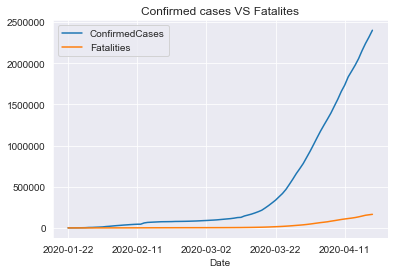

In [27]:
train_df.groupby(by= 'Date')[['ConfirmedCases', 'Fatalities']].sum().plot()
plt.title("Confirmed cases VS Fatalites");

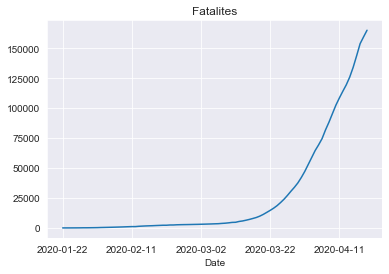

In [28]:
train_df.groupby(by= 'Date')['Fatalities'].sum().plot()
plt.title("Fatalites");

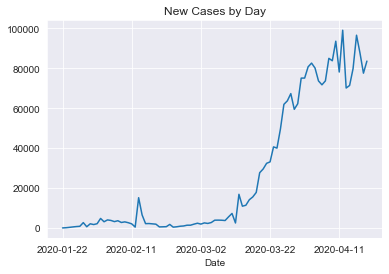

In [29]:
train_df.groupby(by= 'Date')['New_Cases'].sum().plot()
plt.title('New Cases by Day');

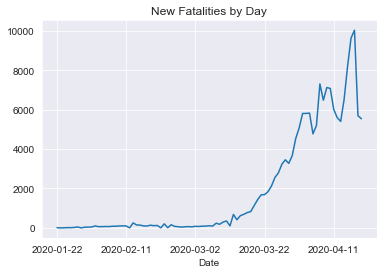

In [30]:
train_df.groupby(by= 'Date')['New_Fatal'].sum().plot()
plt.title('New Fatalities by Day');

In [31]:
latest_df = train_df[train_df['Date'] == train_df['Date'].max()].copy()
latest_df = latest_df.groupby(by = 'Country_Region').sum()
latest_df = latest_df.reset_index()

In [32]:
fig = go.Figure(data=go.Choropleth(
    locations=latest_df['Country_Region'], # Spatial coordinates
    z = latest_df['ConfirmedCases'].astype(float), # Data to be color-coded
    locationmode = 'country names', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "Confirmed Cases",
))

fig.update_layout(
    title_text = 'Covid Total Cases',
#     geo_scope='usa', # limite map scope to USA
)

fig.show()

     Country_Region  ConfirmedCases
171              US        758920.0
156           Spain        198674.0
84            Italy        178972.0
61           France        154097.0
65          Germany        145184.0
175  United Kingdom        121172.0
170          Turkey         86306.0
36            China         83805.0
80             Iran         82211.0


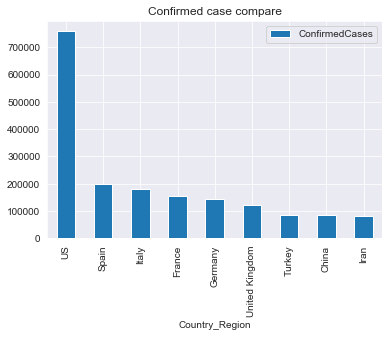

In [33]:
latest_df.loc[latest_df['ConfirmedCases'] > 50000]\
.sort_values(by='ConfirmedCases', ascending = False)\
.plot(x = 'Country_Region', y = 'ConfirmedCases',kind = 'bar')
plt.title("Confirmed case compare");
print(latest_df.loc[latest_df['ConfirmedCases'] > 50000]\
      .sort_values(by='ConfirmedCases', ascending = False)[['Country_Region', 'ConfirmedCases']])

In [34]:
#Globa fatal rate
global_fatal_rate = latest_df.set_index('Country_Region')['Fatalities'] / latest_df.set_index('Country_Region')['ConfirmedCases']
global_fatal_rate = pd.DataFrame(global_fatal_rate, columns=['Fatal_Rate']).sort_values('Fatal_Rate', ascending = False)
global_fatal_rate = global_fatal_rate.reset_index()
global_fatal_rate

Country_Region  Fatal_Rate
0                          MS Zaandam    0.222222
1                             Burundi    0.200000
2                           Nicaragua    0.200000
3                             Bahamas    0.163636
4                               Sudan    0.151515
5                             Belgium    0.147626
6                          Mauritania    0.142857
7                             Algeria    0.142640
8                      United Kingdom    0.132828
9                               Italy    0.132199
10                Antigua and Barbuda    0.130435
11                             France    0.128127
12                           Zimbabwe    0.120000
13                             Malawi    0.117647
14                        Netherlands    0.112583
15                             Belize    0.111111
16                             Guyana    0.107692
17                             Sweden    0.107056
18                              Spain    0.102948
19                           Suriname    0.100000
20                             Gambia    0.100000
21                            Hungary    0.098643
22                           Honduras    0.097458
23                          Indonesia    0.088517
24                            Liberia    0.087912
25                             Mexico    0.086701
26                         San Marino    0.084599
27                             Angola    0.083333
28                              Syria    0.076923
29                   Congo (Kinshasa)    0.076453
30                              Egypt    0.076018
31                Trinidad and Tobago    0.070175
32                           Barbados    0.066667
33                        Philippines    0.065346
34                              Haiti    0.063830
35                             Brazil    0.063693
36                       Burkina Faso    0.062500
37                               Mali    0.062500
38                               Iran    0.062254
39                            Bolivia    0.061538
40                               Togo    0.059524
41                           Slovenia    0.055639
42                              China    0.055319
43                                 US    0.053575
44                               Iraq    0.053281
45                              Kenya    0.051852
46                            Romania    0.051566
47                             Greece    0.050559
48                            Andorra    0.050491
49                        Switzerland    0.050216
50                            Ecuador    0.050063
51                           Botswana    0.050000
52                            Morocco    0.049387
53                             Zambia    0.049180
54                 Dominican Republic    0.048291
55                           Colombia    0.047205
56                           Bulgaria    0.046980
57                            Denmark    0.046834
58                          Argentina    0.046495
59                            Albania    0.046263
60                           Eswatini    0.045455
61                              Burma    0.045045
62                             Canada    0.043908
63                            Tunisia    0.043231
64                            Somalia    0.042683
65                    North Macedonia    0.042254
66                Congo (Brazzaville)    0.041958
67                           Cameroon    0.041298
68                           Tanzania    0.041176
69                            Ireland    0.039997
70                           Paraguay    0.038835
71                             Poland    0.038764
72             Bosnia and Herzegovina    0.037354
73                         Bangladesh    0.037052
74                           Portugal    0.035336
75                          Venezuela    0.035156
76                        El Salvador    0.034826
77                            Nigeria    0.033493
78                        Afghanistan    0.033133
79                     

### Description:

#### Original Columns: 	Id,	Province_State,	Country_Region,	Date,	ConfirmedCases,	Fatalities
- Id: Unique id of each data
- Province_State: Province or State of each country (only US, China, Canada, Austrailia) contains this value
- Country_Regin: Name of country or specific place
- Date: Date period is from 2020-01-22 to 2020-04-19
- ConfirmedCases: Accumulate of people diagnosed as COVID cases by each day
- Fatalities: Accumulate of death by each day

#### Created Columns: New_Cases, New_Fatal
These columns are added for analysis
- New_Cases: Count of COVID cases by each day
- New_Fatal: Count of death by each day



Confirmed cases and fatalities linear plot shows that the confirmed case has spiked up from the end of March. Although fatalities do not seem to be high by comparing confirmed cases, the linear plot by fatalities itself describes a high increase pattern from the end of March. The linear plot of New_Cases is increasing each day, and the New_Fatal linear plot shows that the count of death just hit pick in the middle of April, and it went down immediately.
The choropleth map created with the latest data is showing that the United States has the highest cases. The barplot explains that the current steep increase of COVID 19 cases is from the US, Europian countries, and China.<br>


The fatal rate of each region was extracted to analyze which area has the highest fatal rate. MS Zaandam ( https://en.wikipedia.org/wiki/MS_Zaandam), the cruise ship had the highest fatality rate of all; The cruise was denied to access to the Panama Canal, and passengers were told to stay inside the cruise ship.

---------------------------

# 1.1 Excluding United States
Since the United States have highest records of COVID 19 cases and the region is massive, the US data will be analyzed independently.

In [35]:
# Create dataframe without US
ex_us_df = train_df.drop(axis=0, index=train_df[train_df['Country_Region'] == 'US'].index).copy()

In [36]:
ex_us_df.head()

Id Province_State Country_Region        Date  ConfirmedCases  Fatalities  \
0   1            NaN    Afghanistan  2020-01-22             0.0         0.0   
1   2            NaN    Afghanistan  2020-01-23             0.0         0.0   
2   3            NaN    Afghanistan  2020-01-24             0.0         0.0   
3   4            NaN    Afghanistan  2020-01-25             0.0         0.0   
4   5            NaN    Afghanistan  2020-01-26             0.0         0.0   

   New_Cases  New_Fatal  
0        0.0        0.0  
1        0.0        0.0  
2        0.0        0.0  
3        0.0        0.0  
4        0.0        0.0

In [37]:
# Check if US is dropped
ex_us_df[ex_us_df['Country_Region'] == 'US']

Empty DataFrame
Columns: [Id, Province_State, Country_Region, Date, ConfirmedCases, Fatalities, New_Cases, New_Fatal]
Index: []

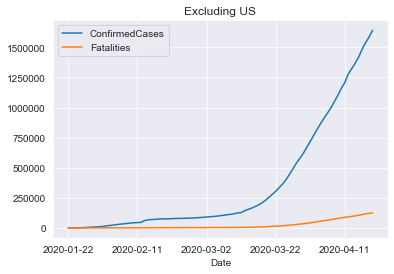

In [38]:
ex_us_df.groupby(by = 'Date').sum()[['ConfirmedCases', 'Fatalities']].plot()
plt.title("Excluding US");

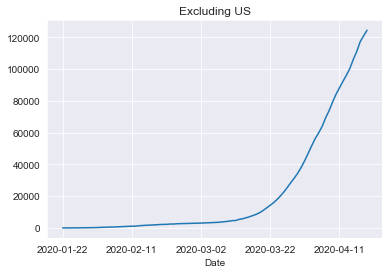

In [39]:
ex_us_df.groupby(by = 'Date').sum()['Fatalities'].plot()
plt.title("Excluding US");

Text(0.5, 1.0, 'New cases & New fatal')

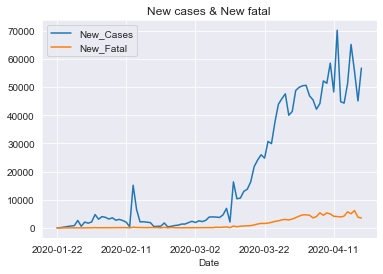

In [42]:
ex_us_df.groupby(by= 'Date')[['New_Cases', 'New_Fatal']].sum().plot()
plt.title("New cases & New fatal")

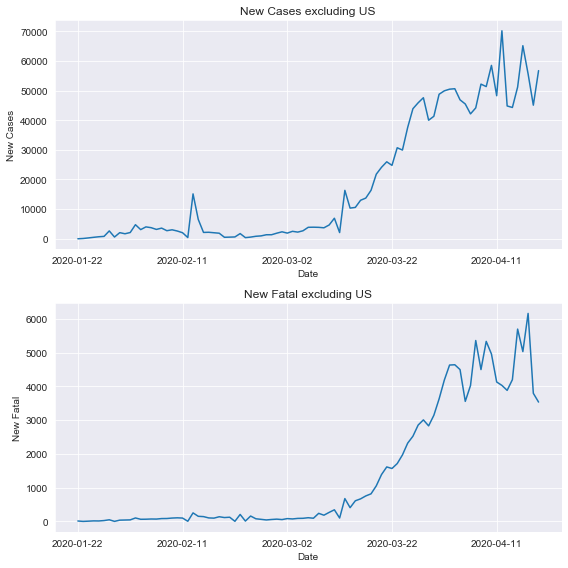

In [49]:
fig, (axe1, axe2) = plt.subplots(2, 1, figsize=(8, 8))

ex_us_df.groupby(by= 'Date')['New_Cases'].sum().plot(ax = axe1)
axe1.set_title('New Cases excluding US')
axe1.set_ylabel('New Cases')

ex_us_df.groupby(by= 'Date')['New_Fatal'].sum().plot(ax = axe2)
axe2.set_title('New Fatal excluding US')
axe2.set_ylabel('New Fatal')

fig.tight_layout();

In [50]:
latest_df[latest_df['Country_Region'] == 'US']['ConfirmedCases'] / latest_df['ConfirmedCases'].sum()

171    0.316059
Name: ConfirmedCases, dtype: float64

In [51]:
latest_df[latest_df['Country_Region'] == 'US']['Fatalities'] / latest_df['Fatalities'].sum()

171    0.246355
Name: Fatalities, dtype: float64

### Description:
Without the United States total number of confirmed cases have decreased by 31% and fatalites have decreased by about 24%. However the pattern of linear model is simillar. New cases and New fatal linear plot is showing bit of decrease in latest date. Hoewver, overall it is showing increasing pattern.

-----------------

# 1.2 United States
Only unites states will be analyzed in this term

In [52]:
US_df = train_df[train_df['Country_Region'] == 'US'].copy()

In [53]:
US_df.head()

Id Province_State Country_Region        Date  ConfirmedCases  \
21093  27019        Alabama             US  2020-01-22             0.0   
21094  27020        Alabama             US  2020-01-23             0.0   
21095  27021        Alabama             US  2020-01-24             0.0   
21096  27022        Alabama             US  2020-01-25             0.0   
21097  27023        Alabama             US  2020-01-26             0.0   

       Fatalities  New_Cases  New_Fatal  
21093         0.0        0.0        0.0  
21094         0.0        0.0        0.0  
21095         0.0        0.0        0.0  
21096         0.0        0.0        0.0  
21097         0.0        0.0        0.0

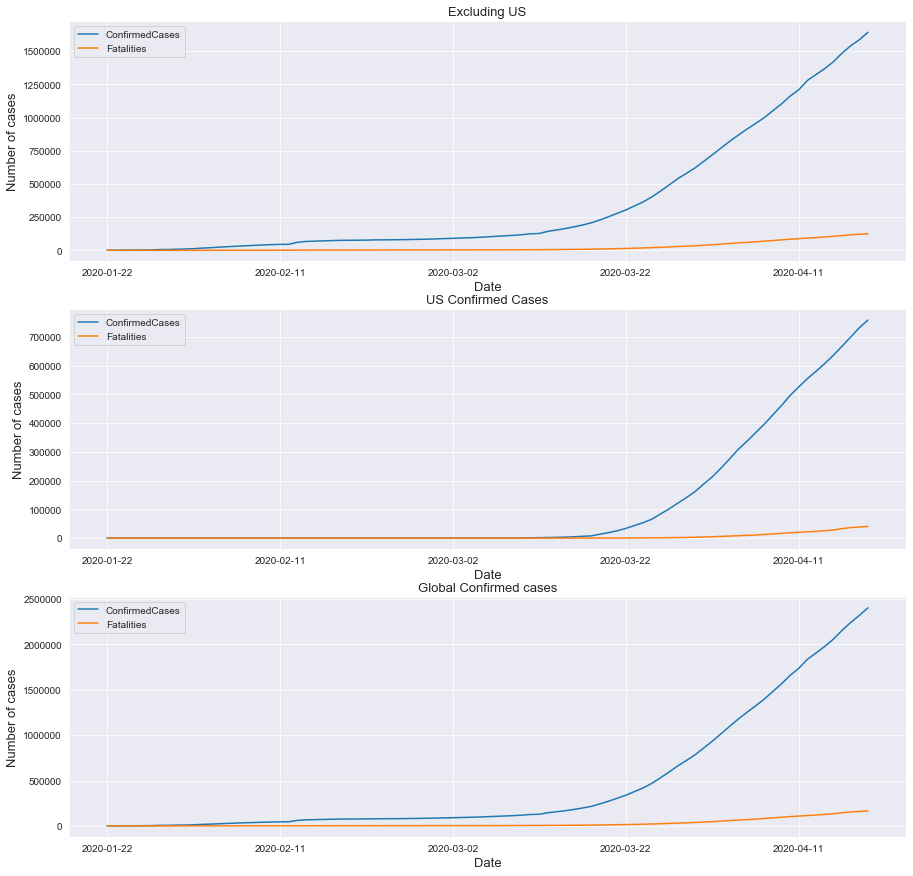

In [54]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15,15))

ex_us_df.groupby(by = 'Date').sum()[['ConfirmedCases', 'Fatalities']].plot(ax=ax1)
ax1.set_title("Excluding US", size=13)
ax1.set_ylabel("Number of cases", size=13)
ax1.set_xlabel("Date", size=13)

US_df.groupby(by='Date').sum()[['ConfirmedCases', 'Fatalities']].plot(ax=ax2)
ax2.set_title("US Confirmed Cases", size=13)
ax2.set_ylabel("Number of cases", size=13)
ax2.set_xlabel("Date", size=13)

train_df.groupby(by= 'Date')[['ConfirmedCases', 'Fatalities']].sum().plot(ax= ax3)
ax3.set_title("Global Confirmed cases", size =13)
ax3.set_ylabel("Number of cases", size=13)
ax3.set_xlabel("Date", size=13);

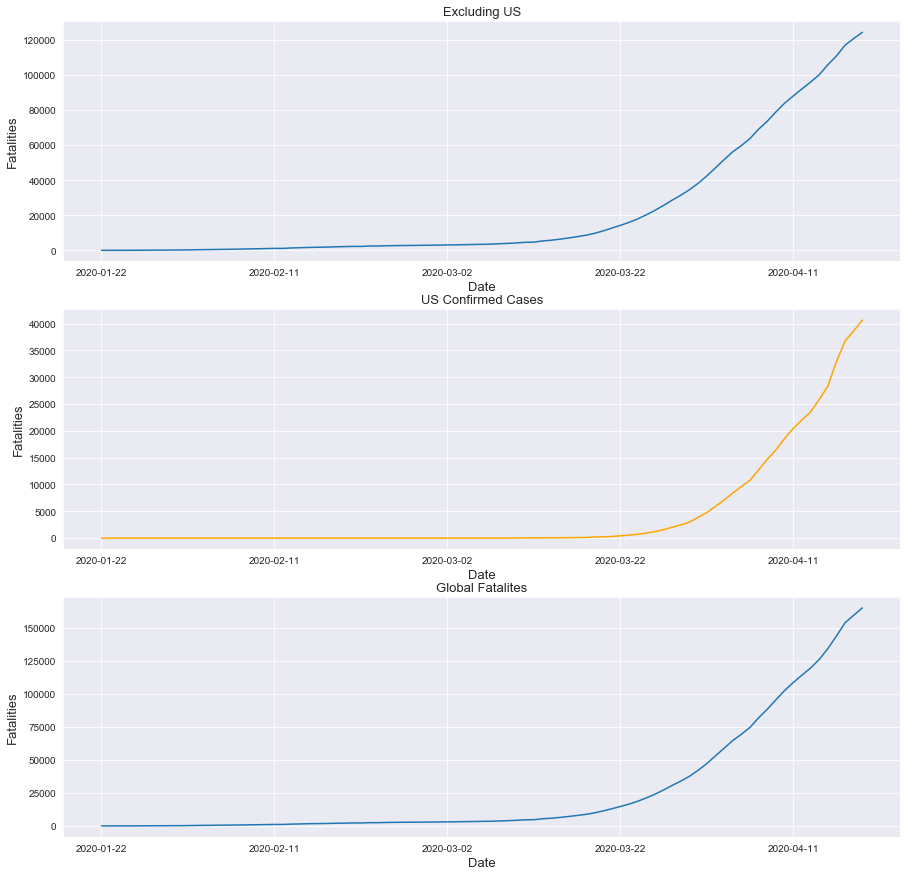

In [55]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15,15))

ex_us_df.groupby(by = 'Date').sum()['Fatalities'].plot(ax=ax1)
ax1.set_title("Excluding US", size=13)
ax1.set_ylabel("Fatalities", size=13)
ax1.set_xlabel("Date", size=13)

US_df.groupby(by='Date').sum()['Fatalities'].plot(ax=ax2, color = 'orange')
ax2.set_title("US Confirmed Cases", size=13)
ax2.set_ylabel("Fatalities", size=13)
ax2.set_xlabel("Date", size=13)

train_df.groupby(by= 'Date')['Fatalities'].sum().plot(ax= ax3)
ax3.set_title("Global Fatalites", size =13)
ax3.set_ylabel("Fatalities", size=13)
ax3.set_xlabel("Date", size=13);

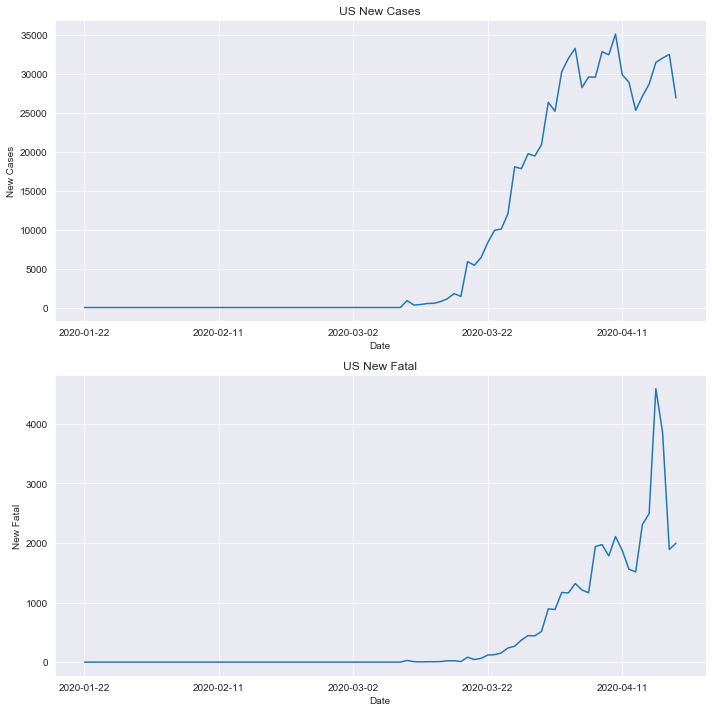

In [91]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10))

US_df.groupby(by='Date').sum()['New_Cases'].plot(ax=ax1)
ax1.set_title('US New Cases')
ax1.set_ylabel('New Cases')

US_df.groupby(by='Date').sum()['New_Fatal'].plot(ax=ax2)
ax2.set_title('US New Fatal')
ax2.set_ylabel('New Fatal')

fig.tight_layout();

In [62]:
US_Date_Sum = US_df.groupby(by='Date').sum()

In [68]:
US_Date_Sum = US_Date_Sum.reset_index()

In [70]:
US_Date_Sum[US_Date_Sum['Date'] > '2020-04-11']

Date       Id  ConfirmedCases  Fatalities  New_Cases  New_Fatal
81  2020-04-12  1626534        555150.0     22017.0    28917.0     1560.0
82  2020-04-13  1626588        580456.0     23526.0    25306.0     1514.0
83  2020-04-14  1626642        607507.0     25829.0    27114.0     2310.0
84  2020-04-15  1626696        636185.0     28323.0    28678.0     2494.0
85  2020-04-16  1626750        667636.0     32914.0    31451.0     4591.0
86  2020-04-17  1626804        699541.0     36771.0    32017.0     3857.0
87  2020-04-18  1626858        732031.0     38662.0    32490.0     1891.0
88  2020-04-19  1626912        758920.0     40659.0    26889.0     1997.0

### Description:

The United States has a different increasing pattern from the global trend, the cases were beginning to increase from the end of March, and it suddenly increased faster than the pattern of the global case.
The United States' fatalities have sharply increased from the end of March. The United States line plot pattern describes that COVID 19 started later than global infection, and it increased faster than any other country.

The new COVID cases count by day are repeating increasing, and decreasing patterns and new death count recorded the highest peak by 4591 on April 16th, the fatal count went down afterward.

#### Analyze by Province_State

In [71]:
US_df_current = US_df[US_df['Date'] == US_df['Date'].max()].copy()

In [72]:
US_df_current.head()

Id Province_State Country_Region        Date  ConfirmedCases  \
21181  27107        Alabama             US  2020-04-19          4888.0   
21270  27221         Alaska             US  2020-04-19           319.0   
21359  27335        Arizona             US  2020-04-19          4933.0   
21448  27449       Arkansas             US  2020-04-19          1781.0   
21537  27563     California             US  2020-04-19         31431.0   

       Fatalities  New_Cases  New_Fatal  
21181       157.0      176.0        4.0  
21270         9.0        5.0        0.0  
21359       184.0      209.0        4.0  
21448        39.0       37.0        1.0  
21537      1177.0      940.0       37.0

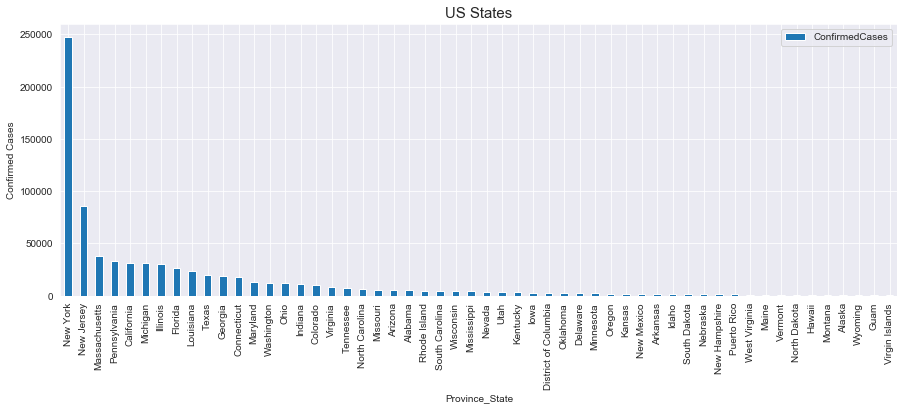

In [73]:
US_df_current.sort_values(by='ConfirmedCases', ascending = False)\
.plot(x = 'Province_State', y = 'ConfirmedCases', kind = 'bar', figsize = (15,5))
plt.title("US States", size = 15)
plt.ylabel("Confirmed Cases");

In [74]:
US_df_current.sort_values(by='ConfirmedCases', ascending = False).head(10)
top_10 = US_df_current.sort_values(by='ConfirmedCases', ascending = False)[:10].copy()

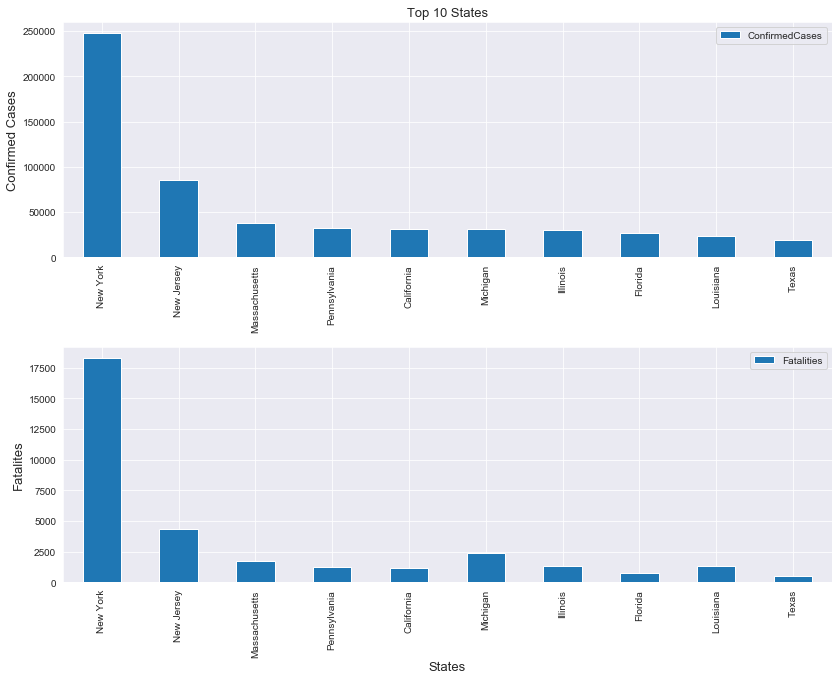

In [75]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13,10))
fig.tight_layout(pad=7.0)

top_10.plot(ax=ax1, x = 'Province_State', y = 'ConfirmedCases', kind = "bar")
ax1.set_title("Top 10 States", size=13)
ax1.set_ylabel("Confirmed Cases", size=13)
ax1.set_xlabel(None)


top_10.plot(ax=ax2, x = 'Province_State', y = 'Fatalities', kind = "bar")
ax2.set_ylabel("Fatalites", size = 13)
ax2.set_xlabel("States", size = 13);

In [76]:
US_fatal_rate = US_df_current.set_index('Province_State')['Fatalities']/US_df_current.set_index('Province_State')['ConfirmedCases']
US_fatal_rate = pd.DataFrame(US_fatal_rate, columns = ['Fatal_Rate'])
US_fatal_rate = US_fatal_rate.sort_values(by='Fatal_Rate', ascending = False)
US_fatal_rate = US_fatal_rate.reset_index()
US_fatal_rate

Province_State  Fatal_Rate
0               Michigan    0.076088
1               New York    0.073837
2            Connecticut    0.062744
3              Minnesota    0.056876
4         Virgin Islands    0.056604
5               Oklahoma    0.054538
6              Louisiana    0.054162
7             Washington    0.051897
8             New Jersey    0.051137
9            Puerto Rico    0.051113
10             Wisconsin    0.050621
11               Indiana    0.050129
12              Kentucky    0.049324
13                Kansas    0.048819
14               Vermont    0.046740
15         Massachusetts    0.044804
16              Colorado    0.043165
17              Illinois    0.042494
18                Nevada    0.042382
19                  Ohio    0.040596
20                 Maine    0.039216
21          Pennsylvania    0.038782
22                Oregon    0.038743
23               Georgia    0.037539
24            California    0.037447
25               Arizona    0.037300
26           Mississippi    0.037202
27                  Guam    0.036765
28              Maryland    0.035884
29              Missouri    0.034651
30  District of Columbia    0.034372
31              Virginia    0.032428
32               Alabama    0.032119
33          Rhode Island    0.031874
34        North Carolina    0.030298
35            New Mexico    0.029810
36               Florida    0.029414
37                Alaska    0.028213
38        South Carolina    0.027416
39         New Hampshire    0.027338
40              Delaware    0.026399
41                 Idaho    0.026379
42                  Iowa    0.025844
43                 Texas    0.025441
44               Montana    0.023095
45              Arkansas    0.021898
46             Tennessee    0.020934
47         West Virginia    0.020225
48              Nebraska    0.018996
49                Hawaii    0.017241
50          North Dakota    0.015385
51                  Utah    0.008798
52               Wyoming    0.006390
53          South Dakota    0.004281

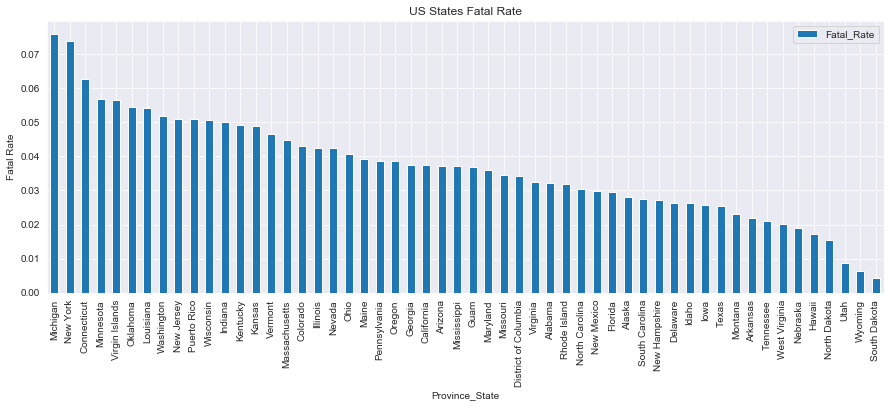

In [77]:
US_fatal_rate.plot(x = 'Province_State', y='Fatal_Rate', kind='bar', figsize = (15,5))
plt.title('US States Fatal Rate')
plt.ylabel('Fatal Rate');

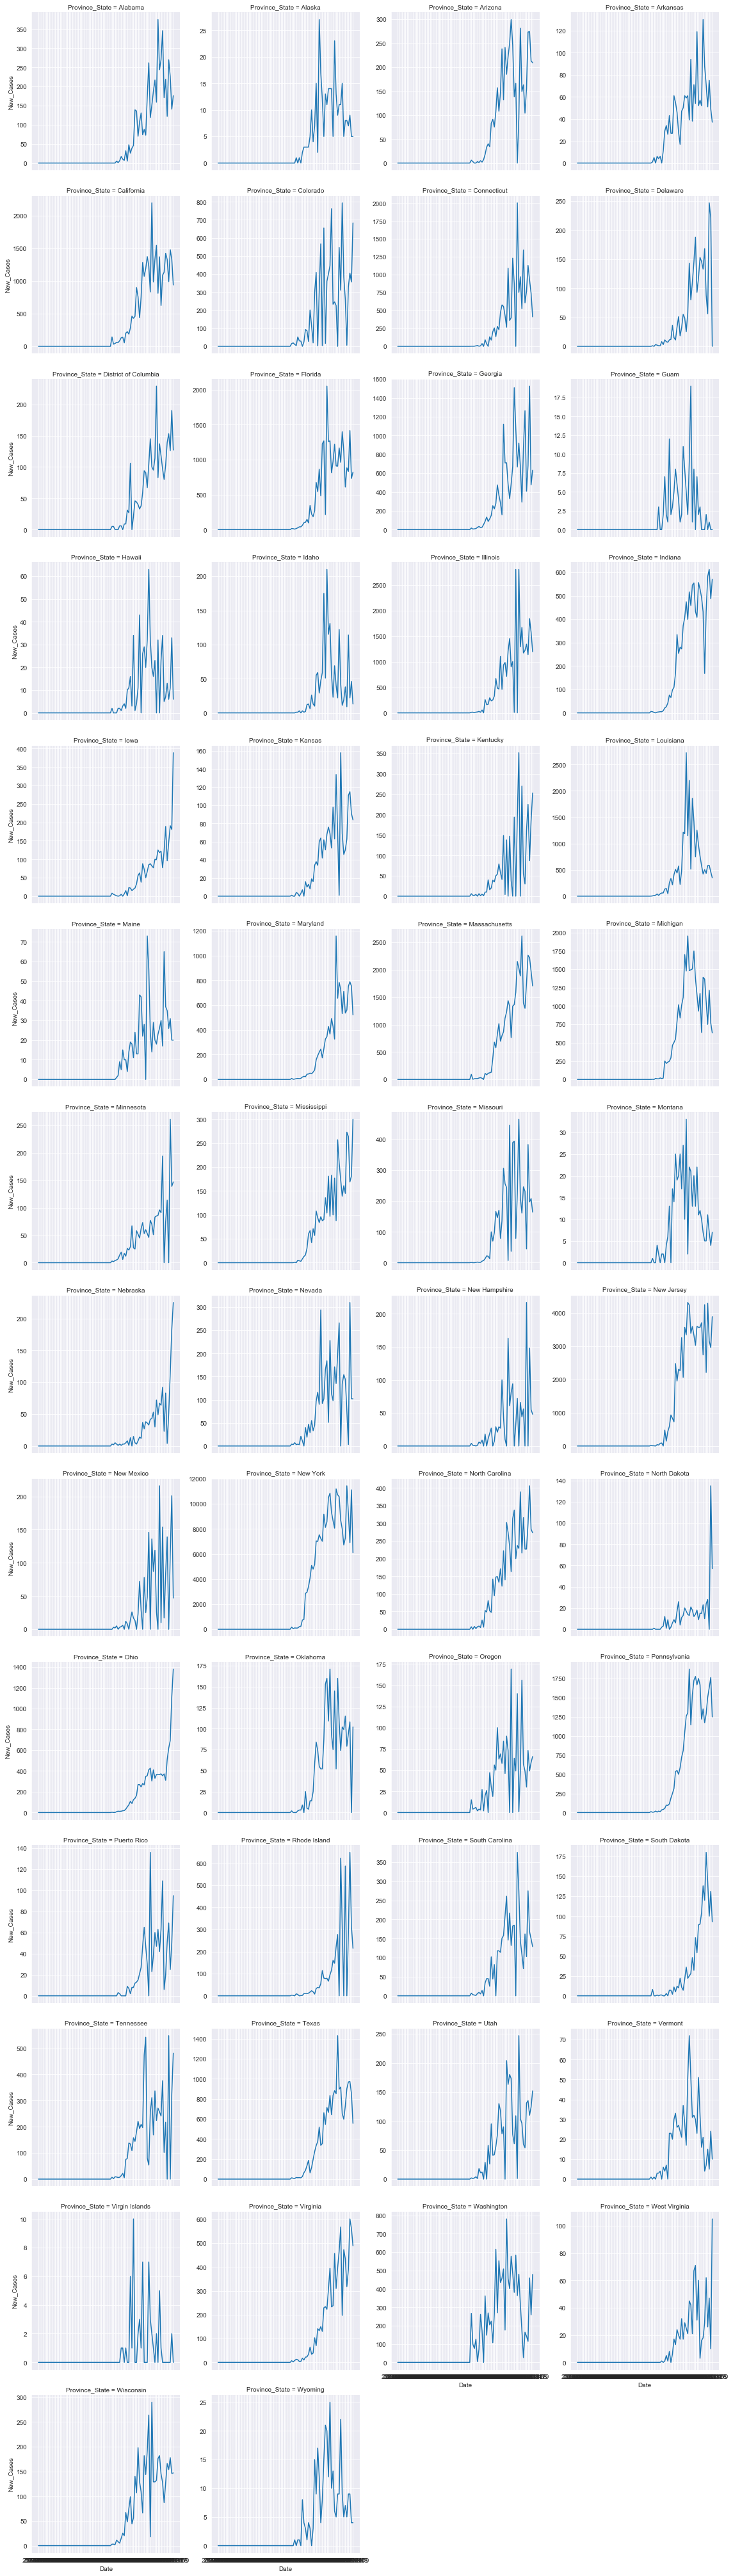

In [109]:
# y tick is not shared
g = sns.FacetGrid(US_New, col = 'Province_State', col_wrap=4, height=4, sharey=False)
g = g.map(plt.plot, "Date", "New_Cases")

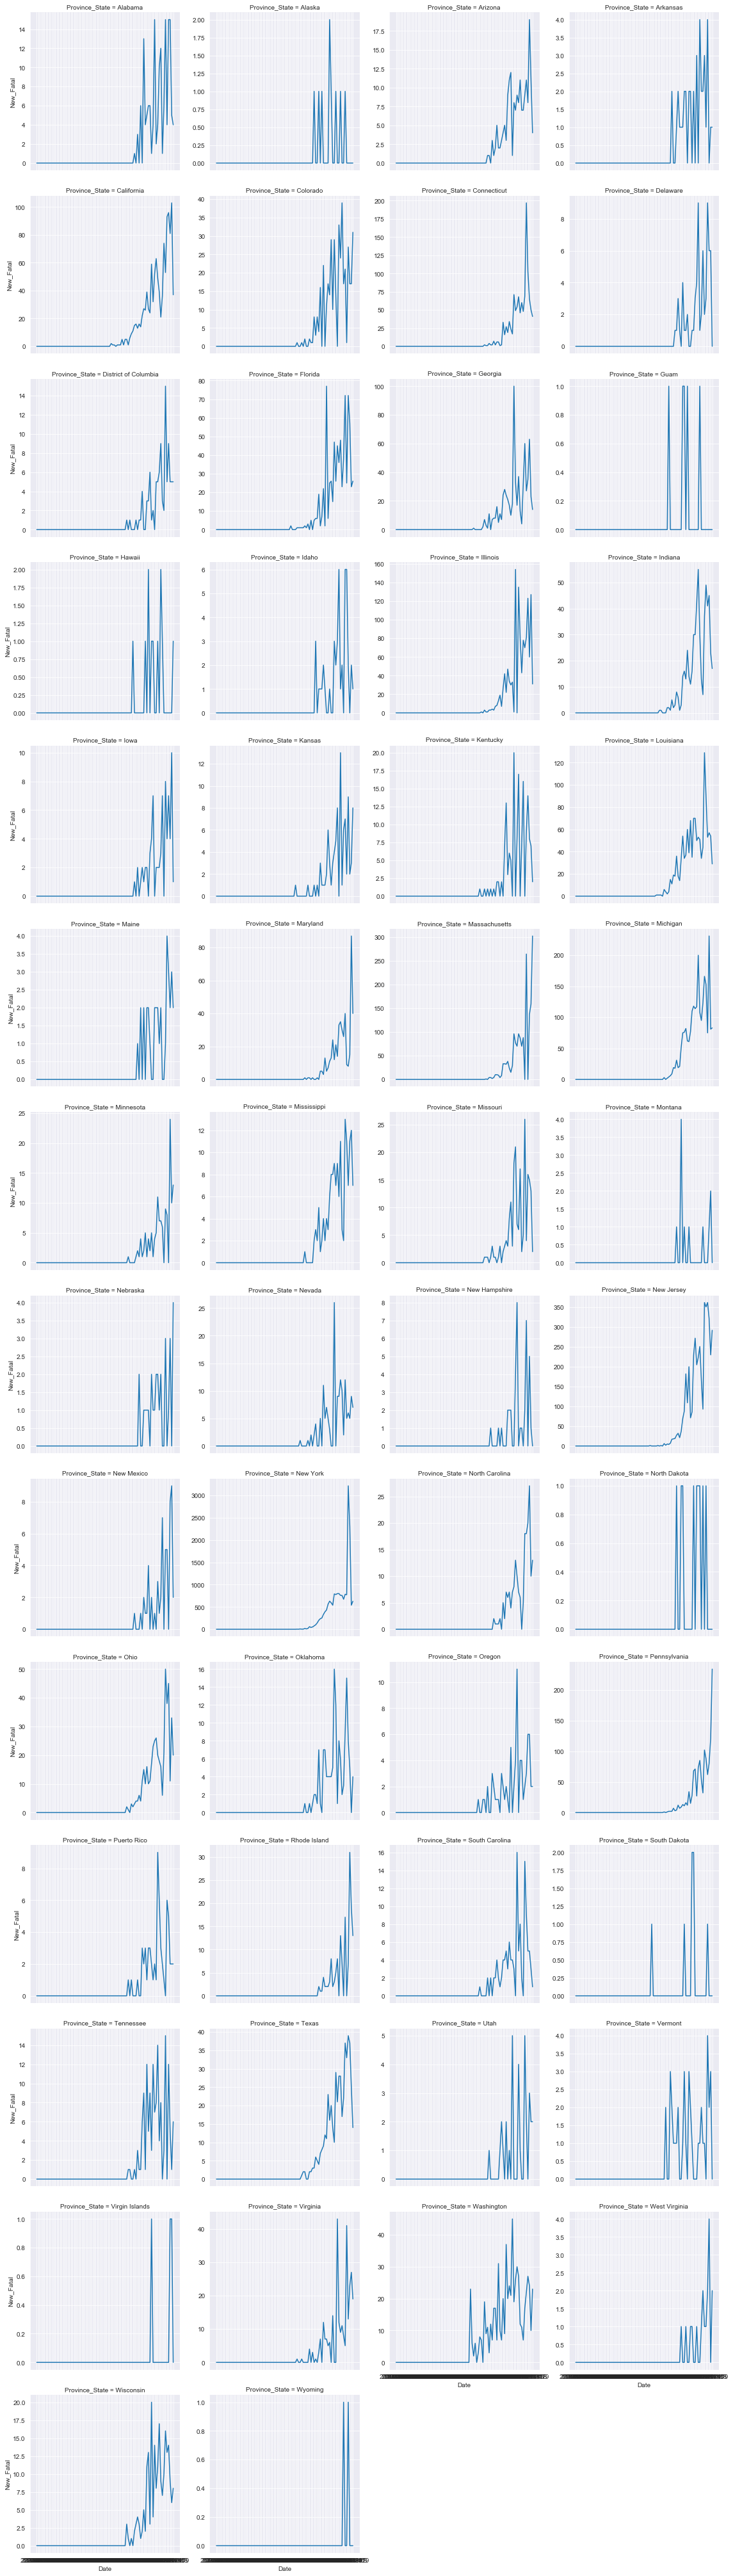

In [108]:
# y tick is not shared
g = sns.FacetGrid(US_New, col = 'Province_State', col_wrap=4, height=4, sharey=False)
g = g.map(plt.plot, "Date", "New_Fatal")

### Description:
New York state overwhelmingly recorded the highest confirmed cases of all the nations with high fatalities. However, comparing the number of fatalities and confirmed cases, Michigan had the highest fatal rate over New York state. Michigan seems to have a problem handling COVID 19 outbreak.

Linear models were plotted to each state by new cases and new fatal to see patterns by each state. Most of the states were showing increasing patterns. 

-------------

# 1. 3 China
China Wuhan city is known as start of COVID 19 outbreak. China data will be analyzed for this section.

In [110]:
China_df = train_df[train_df['Country_Region'] == 'China'].copy()
China_latest = China_df[China_df['Date'] == China_df['Date'].max()].copy()

In [111]:
China_df.head()

Id Province_State Country_Region        Date  ConfirmedCases  \
4806  6157          Anhui          China  2020-01-22             1.0   
4807  6158          Anhui          China  2020-01-23             9.0   
4808  6159          Anhui          China  2020-01-24            15.0   
4809  6160          Anhui          China  2020-01-25            39.0   
4810  6161          Anhui          China  2020-01-26            60.0   

      Fatalities  New_Cases  New_Fatal  
4806         0.0        0.0        0.0  
4807         0.0        8.0        0.0  
4808         0.0        6.0        0.0  
4809         0.0       24.0        0.0  
4810         0.0       21.0        0.0

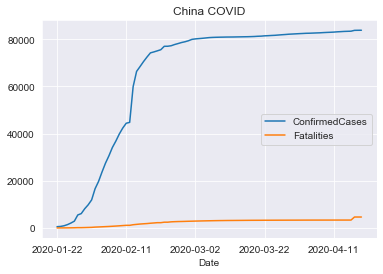

In [112]:
China_df.groupby(by = 'Date')[['ConfirmedCases', 'Fatalities']].sum().plot()
plt.title("China COVID");

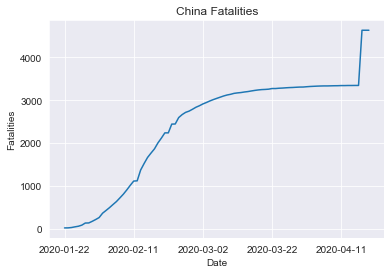

In [113]:
China_df.groupby(by = 'Date')['Fatalities'].sum().plot()
plt.title("China Fatalities")
plt.ylabel("Fatalities");

In [114]:
China_fatal = pd.DataFrame(China_df.groupby(by = 'Date')['Fatalities'].sum(), columns=['Fatalities']).reset_index()
China_fatal[China_fatal['Date'] > "2020-04-11"]

Date  Fatalities
81  2020-04-12      3343.0
82  2020-04-13      3345.0
83  2020-04-14      3345.0
84  2020-04-15      3346.0
85  2020-04-16      3346.0
86  2020-04-17      4636.0
87  2020-04-18      4636.0
88  2020-04-19      4636.0

### Description:
Since COVID was first found from China the linear plot patter is different from other countries. COVID confirmed cases increases to high peak from beginning of the data collection and the curve is now flattened.
Strange pattern has detected from China fatalities, the fatalities suddenly increased between April 16th and April 17th about 1300.

In [115]:
China_latest.head()

Id Province_State Country_Region        Date  ConfirmedCases  \
4894  6245          Anhui          China  2020-04-19           991.0   
4983  6359        Beijing          China  2020-04-19           593.0   
5072  6473      Chongqing          China  2020-04-19           579.0   
5161  6587         Fujian          China  2020-04-19           355.0   
5250  6701          Gansu          China  2020-04-19           139.0   

      Fatalities  New_Cases  New_Fatal  
4894         6.0        0.0        0.0  
4983         8.0        0.0        0.0  
5072         6.0        0.0        0.0  
5161         1.0        0.0        0.0  
5250         2.0        0.0        0.0

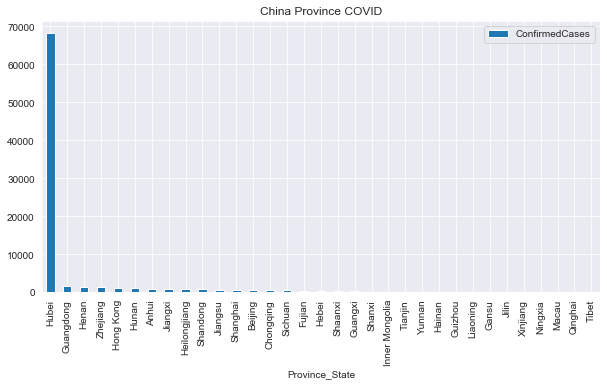

In [116]:
China_latest.sort_values(by = 'ConfirmedCases', ascending=False).plot(x = 'Province_State', y = 'ConfirmedCases', kind = 'bar', figsize = (10,5))
plt.title("China Province COVID");

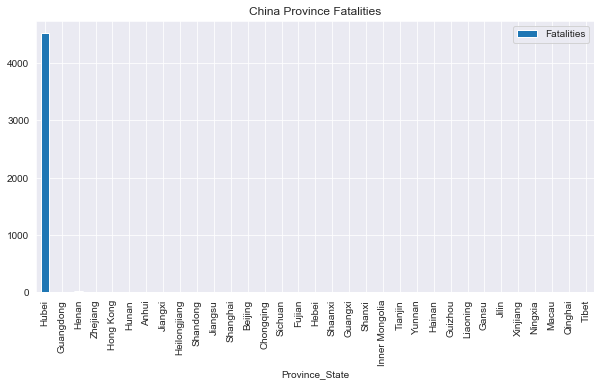

In [117]:
China_latest.sort_values(by = 'ConfirmedCases', ascending=False).plot(x = 'Province_State', y = 'Fatalities', kind = 'bar', figsize = (10,5))
plt.title("China Province Fatalities");
# With Hubei it is hard to see other provinces fatalities

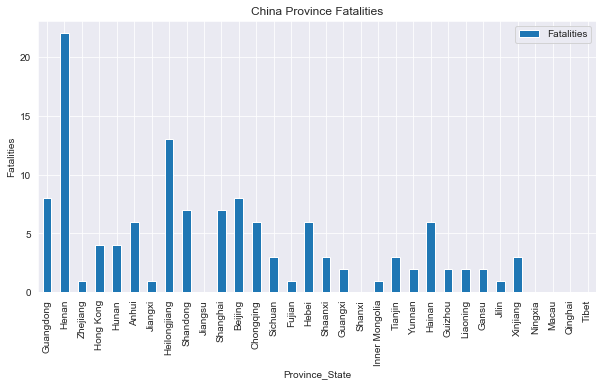

In [118]:
China_latest.drop(index=China_latest[China_latest['Province_State'] == 'Hubei'].index, axis=0)\
.sort_values(by = 'ConfirmedCases', ascending=False).plot(x = 'Province_State', y = 'Fatalities', kind = 'bar', figsize = (10,5))
plt.title("China Province Fatalities")
plt.ylabel("Fatalities");

In [119]:
China_fatal_rate = China_latest.set_index('Province_State')
China_fatal_rate = pd.DataFrame(China_fatal_rate['Fatalities'] / China_fatal_rate['ConfirmedCases'], columns=['Fatal_Rate'])
China_fatal_rate = China_fatal_rate.sort_values(by = 'Fatal_Rate',ascending =False)
China_fatal_rate = China_fatal_rate.reset_index()

In [120]:
China_latest.sort_values(by = 'ConfirmedCases',ascending =False)

Id  Province_State Country_Region        Date  ConfirmedCases  \
6051  7727           Hubei          China  2020-04-19         68128.0   
5339  6815       Guangdong          China  2020-04-19          1580.0   
5873  7499           Henan          China  2020-04-19          1276.0   
7742  9893        Zhejiang          China  2020-04-19          1268.0   
5962  7613       Hong Kong          China  2020-04-19          1025.0   
6140  7841           Hunan          China  2020-04-19          1019.0   
4894  6245           Anhui          China  2020-04-19           991.0   
6407  8183         Jiangxi          China  2020-04-19           937.0   
5784  7385    Heilongjiang          China  2020-04-19           898.0   
7030  8981        Shandong          China  2020-04-19           787.0   
6318  8069         Jiangsu          China  2020-04-19           653.0   
7119  9095        Shanghai          China  2020-04-19           635.0   
4983  6359         Beijing          China  2020-04-19           593.0   
5072  6473       Chongqing          China  2020-04-19           579.0   
7297  9323         Sichuan          China  2020-04-19           561.0   
5161  6587          Fujian          China  2020-04-19           355.0   
5695  7271           Hebei          China  2020-04-19           328.0   
6941  8867         Shaanxi          China  2020-04-19           256.0   
5428  6929         Guangxi          China  2020-04-19           254.0   
7208  9209          Shanxi          China  2020-04-19           197.0   
6229  7955  Inner Mongolia          China  2020-04-19           193.0   
7386  9437         Tianjin          China  2020-04-19           189.0   
7653  9779          Yunnan          China  2020-04-19           184.0   
5606  7157          Hainan          China  2020-04-19           168.0   
5517  7043         Guizhou          China  2020-04-19           147.0   
6585  8411        Liaoning          China  2020-04-19           146.0   
5250  6701           Gansu          China  2020-04-19           139.0   
6496  8297           Jilin          China  2020-04-19           104.0   
7564  9665        Xinjiang          China  2020-04-19            76.0   
6763  8639         Ningxia          China  2020-04-19            75.0   
6674  8525           Macau          China  2020-04-19            45.0   
6852  8753         Qinghai          China  2020-04-19            18.0   
7475  9551           Tibet          China  2020-04-19             1.0   

      Fatalities  New_Cases  New_Fatal  
6051      4512.0        0.0        0.0  
5339         8.0        1.0        0.0  
5873        22.0        0.0        0.0  
7742         1.0        0.0        0.0  
5962         4.0        1.0        0.0  
6140         4.0        0.0        0.0  
4894         6.0        0.0        0.0  
6407         1.0        0.0        0.0  
5784        13.0        6.0        0.0  
7030         7.0        0.0        0.0  
6318         0.0        0.0        0.0  
7119         7.0        7.0        0.0  
4983         8.0        0.0        0.0  
5072         6.0        0.0        0.0  
7297         3.0        0.0        0.0  
5161         1.0        0.0        0.0  
5695         6.0        0.0        0.0  
6941         3.0        0.0        0.0  
5428         2.0        0.0        0.0  
7208         0.0        0.0        0.0  
6229         1.0        0.0        0.0  
7386         3.0        0.0        0.0  
7653         2.0        0.0        0.0  
5606         6.0        0.0        0.0  
5517         2.0        1.0        0.0  
6585         2.0        0.0        0.0  
5250         2.0        0.0        0.0  
6496         1.0        2.0        0.0  
7564         3.0        0.0        0.0  
6763         0.0        0.0        0.0  
6674         0.0        0.0        0.0  
6852         0.0        0.0        0.0  
7475         0.0        0.0        0.0

In [121]:
China_fatal_rate

Province_State  Fatal_Rate
0            Hubei    0.066228
1         Xinjiang    0.039474
2           Hainan    0.035714
3            Hebei    0.018293
4            Henan    0.017241
5          Tianjin    0.015873
6     Heilongjiang    0.014477
7            Gansu    0.014388
8         Liaoning    0.013699
9          Guizhou    0.013605
10         Beijing    0.013491
11         Shaanxi    0.011719
12        Shanghai    0.011024
13          Yunnan    0.010870
14       Chongqing    0.010363
15           Jilin    0.009615
16        Shandong    0.008895
17         Guangxi    0.007874
18           Anhui    0.006054
19         Sichuan    0.005348
20  Inner Mongolia    0.005181
21       Guangdong    0.005063
22           Hunan    0.003925
23       Hong Kong    0.003902
24          Fujian    0.002817
25         Jiangxi    0.001067
26        Zhejiang    0.000789
27          Shanxi    0.000000
28         Qinghai    0.000000
29           Tibet    0.000000
30         Ningxia    0.000000
31           Macau    0.000000
32         Jiangsu    0.000000

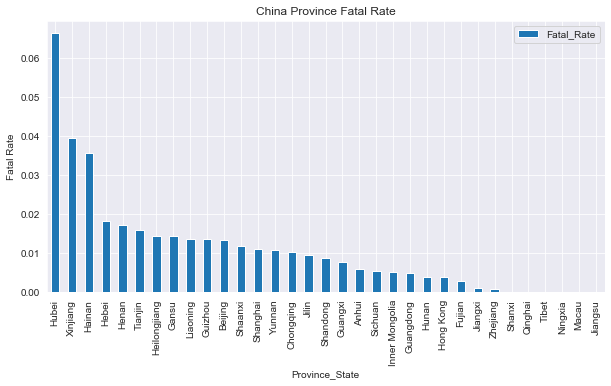

In [123]:
China_fatal_rate.plot(x='Province_State', y = 'Fatal_Rate', kind = 'bar', figsize = (10,5))
plt.title("China Province Fatal Rate")
plt.ylabel("Fatal Rate");

### Description:
Since Hubei is province where Wuhan city is in (https://en.wikipedia.org/wiki/Wuhan), Hubei recorded highest confirmed cases and Fatalities. China may have prevented COVID 19 to spread to other provinces. Confirmed cases outside of Hubei province were lower than 1600 and most of the province had fatlities lower than 10. In this case fatal rate is not efficient since 1 increace in fatalities can cause higher pecentage increase in fatal rate.

C:\Users\chi\Anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



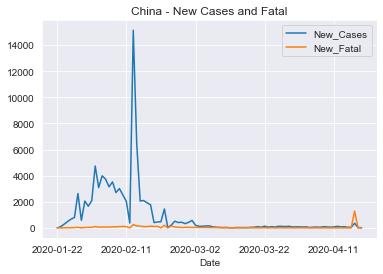

In [125]:
China_df.groupby(by = 'Date')['New_Cases', 'New_Fatal'].sum().plot()
plt.title('China - New Cases and Fatal');

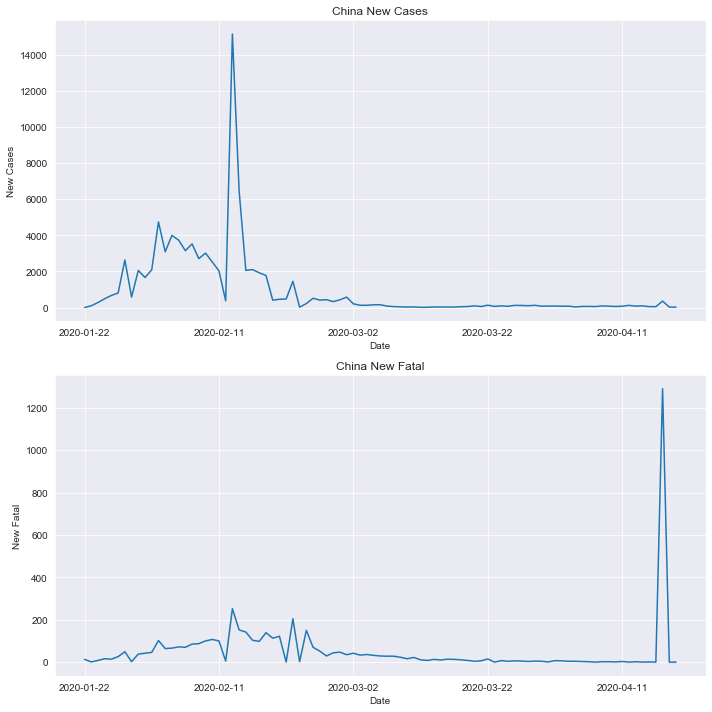

In [133]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10))

China_df.groupby(by = 'Date')['New_Cases'].sum().plot(ax = ax1)
ax1.set_title('China New Cases')
ax1.set_ylabel('New Cases')

China_df.groupby(by = 'Date')['New_Fatal'].sum().plot(ax = ax2)
ax2.set_title('China New Fatal')
ax2.set_ylabel('New Fatal')

fig.tight_layout();

### Description:

China's COVID new case is now flattened. However, the new fatal count spiked up in April.

------------------

# 1. 4 South Korea
From current news, South Korea have flattened the coronavirus Curve. https://www.nytimes.com/2020/03/23/world/asia/coronavirus-south-korea-flatten-curve.html <br>
South Korea data will be analyzed individually.

In [134]:
Korea_df = train_df[train_df['Country_Region'] == 'Korea, South'].copy()

In [135]:
# Korea_df does not need group by since Province_State value is not in data
Korea_df.head()

Id Province_State Country_Region        Date  ConfirmedCases  \
13528  17329            NaN   Korea, South  2020-01-22             1.0   
13529  17330            NaN   Korea, South  2020-01-23             1.0   
13530  17331            NaN   Korea, South  2020-01-24             2.0   
13531  17332            NaN   Korea, South  2020-01-25             2.0   
13532  17333            NaN   Korea, South  2020-01-26             3.0   

       Fatalities  New_Cases  New_Fatal  
13528         0.0        0.0        0.0  
13529         0.0        0.0        0.0  
13530         0.0        1.0        0.0  
13531         0.0        0.0        0.0  
13532         0.0        1.0        0.0

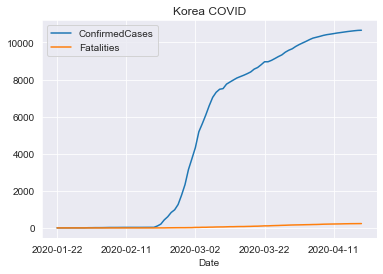

In [136]:
Korea_df.set_index('Date')[['ConfirmedCases', 'Fatalities']].plot()
plt.title('Korea COVID');

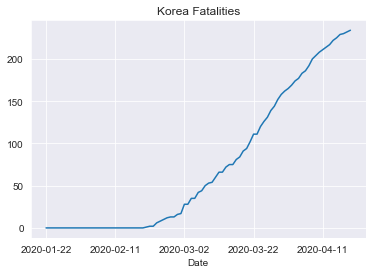

In [137]:
Korea_df.set_index('Date')['Fatalities'].plot()
plt.title('Korea Fatalities');

In [222]:
Korea_df[Korea_df['Date'] == Korea_df['Date'].max()]['Fatalities'] / Korea_df[Korea_df['Date'] == Korea_df['Date'].max()]['ConfirmedCases']

13616    0.021949
dtype: float64

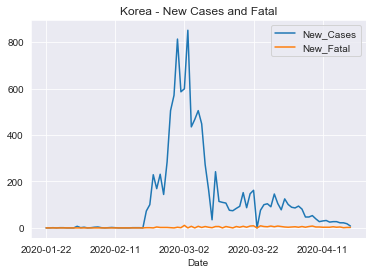

In [143]:
Korea_df.set_index('Date')[['New_Cases', 'New_Fatal']].plot()
plt.title('Korea - New Cases and Fatal');

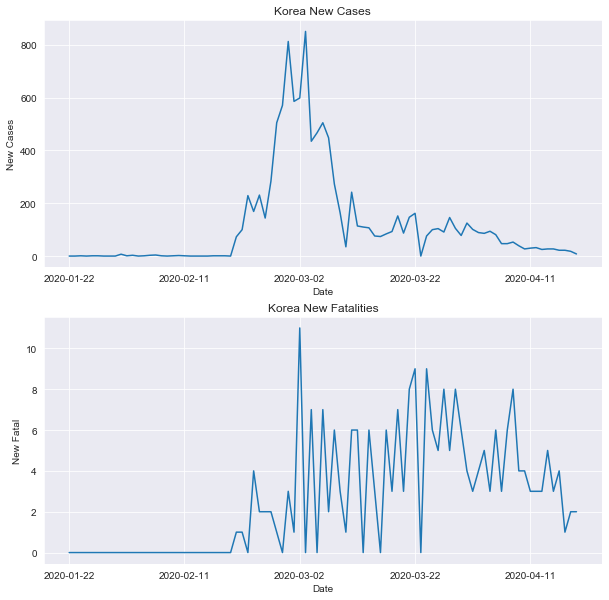

In [141]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10))

Korea_df.set_index('Date')['New_Cases'].plot(ax = ax1)
ax1.set_title('Korea New Cases')
ax1.set_ylabel('New Cases')

Korea_df.set_index('Date')['New_Fatal'].plot(ax = ax2)
ax2.set_title('Korea New Fatalities')
ax2.set_ylabel('New Fatal');

### Description:
South Korea confirmed case trend is flattening. New cases recorded highest in March, and the new cases count started to decline. South Korea's fatal is very low comparing to other countries; it's overall below 10 in each day.

-------------------------------------------

# Conclusion

The world is suffering from COVID 19; lots of people are getting infected and dying because of the virus. The United States is still in the increasing stage of infection, and if the Unites States keep regulating the people stay at home and keep distance, there is a chance that the United States new cases curve will be flattened as South Korea line plot. It seems too early to re-open the country without any treatment or vaccine for COVID 19, and if we open without them, the United States' new case plot will find another peak.